Загрузить данные: 'insurance.csv'. Вывести и провести предобработку. Вывести список уникальных регионов.

In [1]:
import pandas as pd
import numpy as np

read = pd.read_csv('insurance.csv')

df = pd.DataFrame(read, index=None)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
df = df.drop_duplicates()
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [4]:
df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя первый способ, через библиотеку Scipy.

In [25]:
import scipy.stats as sts
voter_region = df.region
voter_bmi = df.bmi
voter_frame = pd.DataFrame({'region':df.region, 'BMI':df.bmi})
groups = voter_frame.groupby('region').groups

sw = voter_bmi[groups['southwest']]
se = voter_bmi[groups['southeast']]
nw = voter_bmi[groups['northwest']]
ne = voter_bmi[groups['northeast']]

sts.f_oneway(sw, se, nw, ne)

F_onewayResult(statistic=39.48593864487439, pvalue=1.9087293927440606e-24)

Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя второй способ, с помощью функции anova_lm() из библиотеки statsmodels.

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('BMI ~ region', data=voter_frame).fit()
anova_res = sm.stats.anova_lm(model, typ=2)
print(anova_res)

                sum_sq      df          F        PR(>F)
region     4057.813904     3.0  39.485939  1.908729e-24
Residual  45662.381091  1333.0        NaN           NaN


С помощью t критерия Стьюдента перебрать все пары. Определить поправку Бонферрони. Сделать выводы.

In [24]:
region_pairs = []

for region1 in range(3):
    for region2 in range(region1 +1, 4):
        region_pairs.append((df.region[region1], df.region[region2]))

for region1, region2 in region_pairs:
    print(region1, region2)
    print(sts.ttest_ind(voter_bmi[groups[region1]], voter_bmi[groups[region2]]))

southwest southeast
Ttest_indResult(statistic=-5.908373821545118, pvalue=5.4374009639680636e-09)
southwest southeast
Ttest_indResult(statistic=-5.908373821545118, pvalue=5.4374009639680636e-09)
southwest northwest
Ttest_indResult(statistic=3.289593460501664, pvalue=0.0010577505931067947)
southeast southeast
Ttest_indResult(statistic=0.0, pvalue=1.0)
southeast northwest
Ttest_indResult(statistic=9.252137489219615, pvalue=2.7504255547794223e-19)
southeast northwest
Ttest_indResult(statistic=9.252137489219615, pvalue=2.7504255547794223e-19)


Выполнить пост-хок тесты Тьюки и построить график

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.022,1.0,-1.1608,1.2048,False
northeast,southeast,4.1825,0.0,3.0326,5.3324,True
northeast,southwest,1.4231,0.0107,0.2412,2.605,True
northwest,southeast,4.1605,0.0,3.0106,5.3104,True
northwest,southwest,1.4011,0.0125,0.2192,2.583,True
southeast,southwest,-2.7594,0.0,-3.9083,-1.6104,True


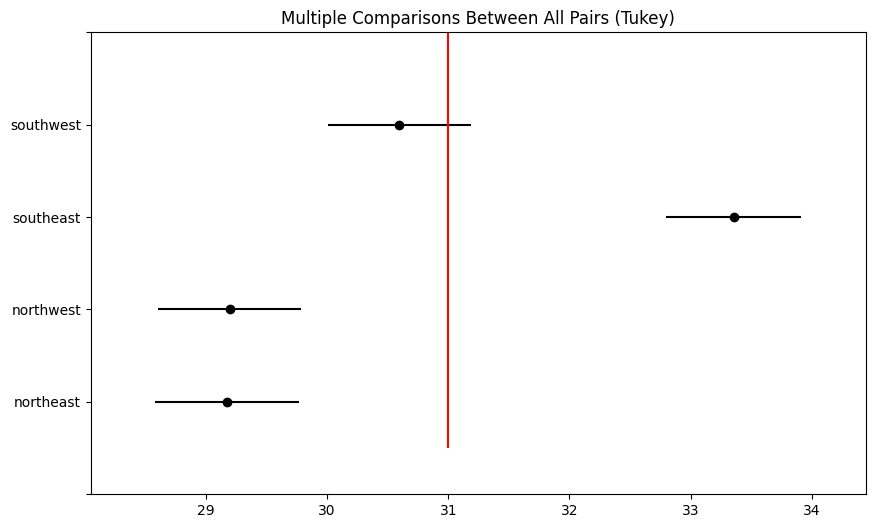

In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt

tukey = pairwise_tukeyhsd(endog=voter_bmi, groups=voter_region, alpha=0.05)
tukey.plot_simultaneous()
plt.vlines(x = 31, ymin = -0.5, ymax = 4.5, color = 'red')
tukey.summary()

Выполнить двухфакторный ANOVA тест, чтобы проверить влияние региона и пола на индекс массы тела (BMI), используя функцию anova_lm() из библиотеки statsmodels.

In [35]:
model = ols('bmi ~ C(region) + C(sex) + C(region):C(sex)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(region),4036.141807,3.0,39.381780,2.215903e-24
C(sex),85.359929,1.0,2.498643,1.141824e-01
C(region):C(sex),175.040197,3.0,1.707917,1.635099e-01
Residual,45401.980965,1329.0,NaN,NaN


Выполнить пост-хок тесты Тьюки и построить график.

C:\Users\icebe\AppData\Local\Temp\ipykernel_11000\4077594609.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



group1,group2,meandiff,p-adj,lower,upper,reject
female / northeast,female / northwest,-0.0464,1.0,-2.0149,1.9222,False
female / northeast,female / southeast,3.3469,0.0,1.4093,5.2846,True
female / northeast,female / southwest,0.7362,0.9498,-1.2384,2.7107,False
female / northeast,male / northeast,-0.2998,0.9998,-2.2713,1.6718,False
female / northeast,male / northwest,-0.2133,1.0,-2.194,1.7674,False
female / northeast,male / southeast,4.6657,0.0,2.7627,6.5686,True
female / northeast,male / southwest,1.8051,0.101,-0.1664,3.7767,False
female / northwest,female / southeast,3.3933,0.0,1.4649,5.3217,True
female / northwest,female / southwest,0.7825,0.9295,-1.1829,2.748,False
female / northwest,male / northeast,-0.2534,0.9999,-2.2159,1.709,False


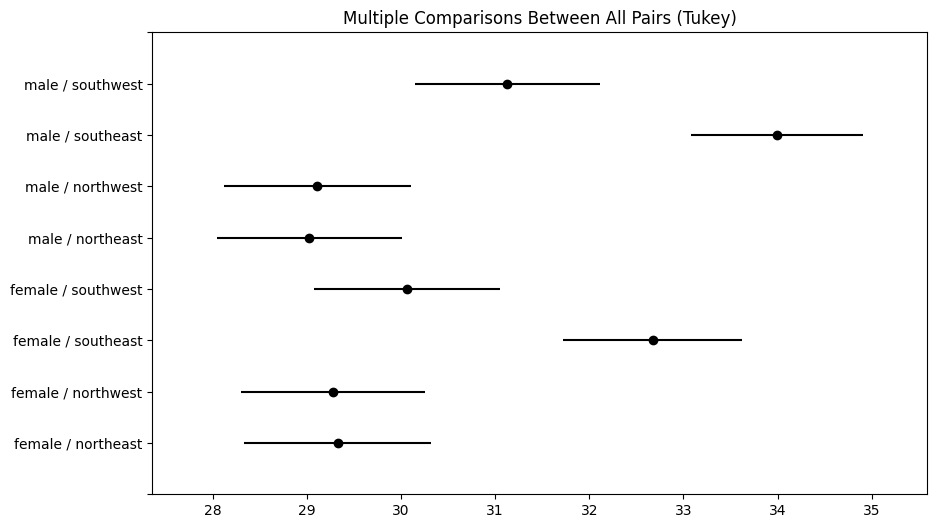

In [39]:
df['combinations'] = df.sex + ' / ' + df.region

tukey = pairwise_tukeyhsd(endog=voter_bmi, groups=df['combinations'], alpha=0.05)
tukey.plot_simultaneous()
tukey.summary()